 ## **Import libaries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

 ## **Load and plot dataset**

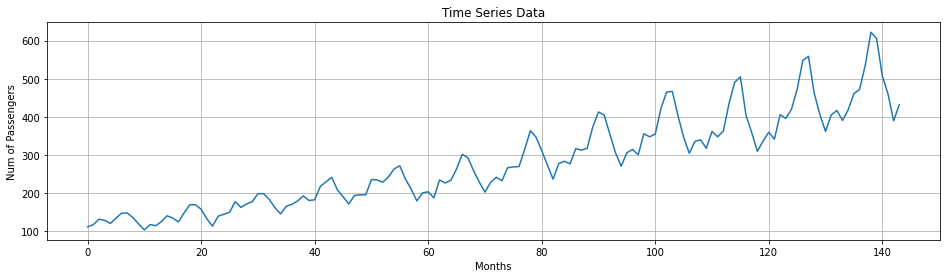

In [ ]:
data = sns.load_dataset("flights")

plt.figure(figsize=(16,4))
plt.title("Time Series Data");
plt.plot(data['passengers'])
plt.xlabel('Months')
plt.ylabel('Num of Passengers')
plt.grid()

 ## **MinMax scaling and split dataset into training and test set**

 ##### All data points in the dataset before the date '1956-12' should be training set and all datapoints on the date and after should be part of test set.

##### Remove the 'Month' column from the datatset as it is not needed after this point.

##### The final name of the training and test sets must be train_X and test_X (**Note: This is required for the proper working of the subsequent cells.**)

In [ ]:
scaler = MinMaxScaler()
data[['passengers']] = scaler.fit_transform(data[['passengers']])

train_X = data[data['year']<1957]
test_X  = data[data['year']>=1957]

## **Generate sequences and the corresponding labels for both training and test set**

In [ ]:
sequence_length = 10
n_steps=20
col1 = "Month"
col2 = "passengers"


# Function to create sequences
def gen1(id_df, seq_length, seq_cols):
  samples = list()
  data_array = id_df[seq_cols].values
  num_elements = data_array.shape[0]
  for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
    samples.append(data_array[start:stop, :])
  dat = np.array(samples)
  dat = dat.reshape((len(samples), seq_length, 1))
  return dat

# create X_train and Y_train
seq_array = gen1(train_X, sequence_length + n_steps, [col2])
X_train = seq_array[:, :sequence_length]
Y_train = np.empty((X_train.shape[0], sequence_length, n_steps))
for step_ahead in range(1, n_steps + 1):
    Y_train[..., step_ahead - 1] = seq_array[..., step_ahead:step_ahead + sequence_length, 0]

# create X_test and Y_test
seq_array1 = gen1(test_X, sequence_length + n_steps, [col2])
X_test = seq_array1[:, :sequence_length]
Y_test = np.empty((X_test.shape[0], sequence_length, n_steps))
for step_ahead in range(1, n_steps + 1):
    Y_test[..., step_ahead - 1] = seq_array1[..., step_ahead:step_ahead + sequence_length, 0]


# X_train.shape[0] # = 66
# X_test.shape[0]  # = 18

# final training sequence 
X_train, Y_train = X_train.reshape(X_train.shape[0] ,sequence_length), Y_train.reshape(X_train.shape[0] ,sequence_length*n_steps)
print(X_train.shape, Y_train.shape)

# final test sequence
X_test, Y_test = X_test.reshape(X_test.shape[0],sequence_length), Y_test.reshape(X_test.shape[0],sequence_length*n_steps)
print(X_test.shape, Y_test.shape)

# Create first test sequence to be used to test each of the models below
X_new, Y_new = X_test[0:1], Y_test[0:1]
print(X_new.shape, Y_new.shape)


# Convert X_train, Y_train, X_test, Y_test and X_new to tensors
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
X_new  = torch.from_numpy(X_new).float()



(66, 10) (66, 200)
(18, 10) (18, 200)
(1, 10) (1, 200)


## **Make sequences into batches**

##### Specify batch_size

In [ ]:
batch_size= 66

train_data =[]
for i in range(len(X_train)):
  train_data.append([X_train[i], Y_train[i]])

test_data = []
for i in range(len(X_test)):
  test_data.append([X_test[i], Y_test[i]])


train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size= batch_size)

# for batch in test_loader:
#   print(batch[0].shape)
#   print(batch[0].dtype)
#   print(batch[0].float().dtype)
#   print(batch[1].shape)

## **Define function to plot training and validation loss**

In [ ]:
def plot_training_validation_loss(train_loss,val_loss,epochs):
  plt.figure(figsize=(12,4));
  x = [i+1 for i in range(epochs)]
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.plot(x, train_loss, color='blue', label='train')
  plt.plot(x, val_loss,   color='red', label='test') 
  plt.grid()
  plt.legend()

## **Define function to plot the time series predictions**

In [ ]:
def plot_true_predicted_forecast(preds):
  plt.figure(figsize=(12,4));
  #print(X_new.reshape(sequence_length))
  plt.title("Predicted Time Series")
  
  input_seen_by_model = scaler.inverse_transform( X_new.reshape(sequence_length,1) ).reshape(sequence_length)
  actual              = scaler.inverse_transform( Y_new.reshape(sequence_length*n_steps)[-1*n_steps:].reshape(n_steps,1) ).reshape(n_steps)
  predicted           = scaler.inverse_transform( preds.reshape(sequence_length*n_steps)[-1*n_steps:].reshape(n_steps,1) ).reshape(n_steps)

  plt.plot( [i for i in range(sequence_length)]         , input_seen_by_model )
  plt.plot( [i+sequence_length for i in range(n_steps)] , actual,          label='Actual', color='red')
  plt.plot( [i+sequence_length for i in range(n_steps)] , predicted,       label='Predicted', color='blue')

  plt.xlabel('Month')
  plt.ylabel('Passengers') 
  plt.grid()
  plt.legend()


## **Define function to train model**

In [ ]:
def fit(model,epochs):
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  train_loss, val_loss = [],[]

  for epoch in range(epochs):
    
    # Training set
    loss_per_epoch = 0
    for batch in train_loader:

      X_train = batch[0]
      Y_train = batch[1]

      preds = model(X_train) #implements the forward pass
      loss  = F.mse_loss(preds, Y_train)
  
      optimizer.zero_grad()
      loss.backward() # Compute the gradient for each of the weights
      optimizer.step()

      loss_per_epoch += 1/len(train_data)*loss.item()

    train_loss.append(loss_per_epoch)


    # Test set
    with torch.no_grad():

      loss_per_epoch = 0
      for batch in test_loader:

        X_test = batch[0]
        Y_test = batch[1]

        preds = model(X_test) #implements the forward pass
        loss  = F.mse_loss(preds, Y_test)

        loss_per_epoch += 1/len(test_data)*loss.item()
    val_loss.append(loss.item())
  
  return( train_loss, val_loss )


# **RNN model (stateless) to predict 20 steps in the future (n_steps=20)**

##### Construct a simple RNN model with 2 hidden layers and 4 nodes per layer. An output layer with 'n_steps' number of nodes.

##### Print the model summary.

In [ ]:
torch.manual_seed(67)

class RNN_model_stateless(nn.Module):

  def __init__(self, input_features, hidden_size, n_steps):
    super().__init__()

    self.input_features    = input_features
    self.hidden_size       = hidden_size
    self.n_steps           = n_steps
    
    # torch.nn.RNNCell(input_size, hidden_size, bias=True, nonlinearity='tanh')
    self.rnn1 = nn.RNNCell(input_size=input_features, hidden_size=hidden_size, nonlinearity='relu')
    self.rnn2 = nn.RNNCell(input_size=hidden_size,    hidden_size=hidden_size, nonlinearity='relu')
    self.output = nn.Linear(in_features = hidden_size, out_features = n_steps)

  def forward(self, input):

    outputs = []
    
    # reset the states every batch
    h_t  = torch.zeros(input.size(0), self.hidden_size)
    h_t2 = torch.zeros(input.size(0), self.hidden_size)

    for input_t in input.split(1, dim=1):
      h_t   = self.rnn1(input_t, h_t )
      h_t2  = self.rnn2(h_t,     h_t2)
      output = self.output(h_t2)
      outputs += [output]

    outputs = torch.cat(outputs, dim=1)
    return outputs

RNN_model_stateless = RNN_model_stateless(1,4,n_steps)
print(RNN_model_stateless)

RNN_model_stateless(
  (rnn1): RNNCell(1, 4, nonlinearity=relu)
  (rnn2): RNNCell(4, 4, nonlinearity=relu)
  (output): Linear(in_features=4, out_features=20, bias=True)
)


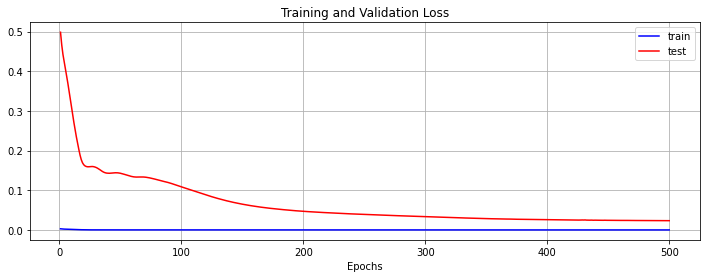

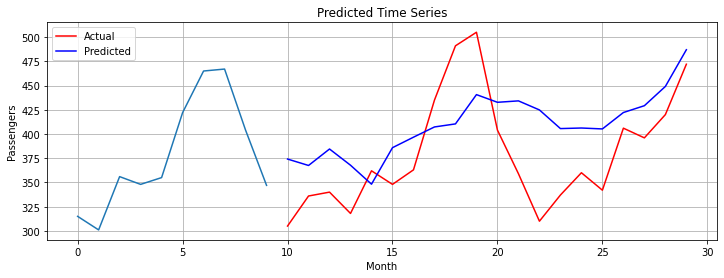

In [ ]:
# Plot training and validation loss
train_loss, val_loss = fit(RNN_model_stateless,500)
plot_training_validation_loss(train_loss,val_loss,500)

# Use the model to make prediction
with torch.no_grad():
  new_preds = RNN_model_stateless(X_new)

# Plot Predicted Time Series
plot_true_predicted_forecast(new_preds)

# **LSTM model (stateless) to predict 20 steps in the future (n_steps=20)**


##### Construct a simple RNN model with 2 hidden layers and 4 nodes per layer. An output layer with 'n_steps' number of nodes.

##### Print the model summary.

In [ ]:
torch.manual_seed(68)

class LSTM_model(nn.Module):

  def __init__(self, input_features, hidden_size, n_steps):
    super().__init__()

    self.input_features    = input_features
    self.hidden_size       = hidden_size
    self.n_steps           = n_steps
    
    # torch.nn.LSTMCell(input_size, hidden_size, bias=True)
    self.lstm1 = nn.LSTMCell(input_size=input_features, hidden_size=hidden_size)
    self.lstm2 = nn.LSTMCell(input_size=hidden_size,    hidden_size=hidden_size)
    self.output = nn.Linear(in_features = hidden_size, out_features = n_steps)

  def forward(self, input):

    outputs = []
    
    # reset the states every batch
    h_t  = torch.zeros(input.size(0), self.hidden_size)
    c_t  = torch.zeros(input.size(0), self.hidden_size)
    h_t2 = torch.zeros(input.size(0), self.hidden_size)
    c_t2 = torch.zeros(input.size(0), self.hidden_size)

    for input_t in input.split(1, dim=1):
      h_t, c_t   = self.lstm1(input_t, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.output(h_t2)
      outputs += [output]

    outputs = torch.cat(outputs, dim=1)
    return outputs
  
LSTM_model = LSTM_model(1,4,n_steps)
print(LSTM_model)

LSTM_model(
  (lstm1): LSTMCell(1, 4)
  (lstm2): LSTMCell(4, 4)
  (output): Linear(in_features=4, out_features=20, bias=True)
)


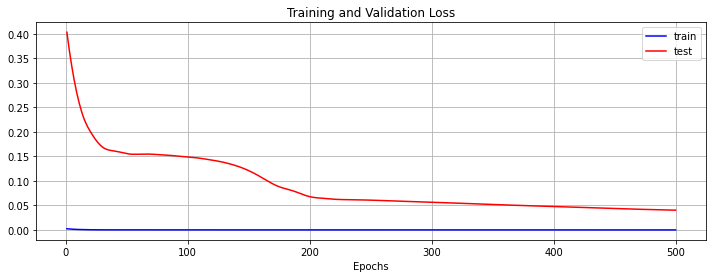

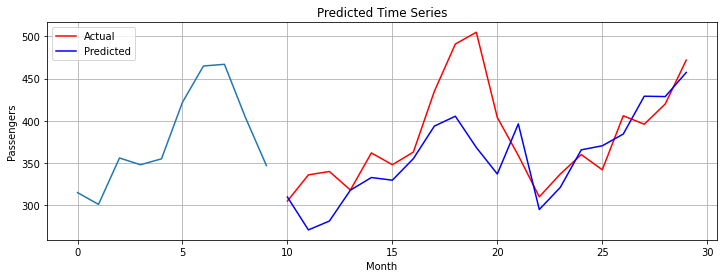

In [ ]:
# Plot training and validation loss
train_loss, val_loss = fit(LSTM_model,500)
plot_training_validation_loss(train_loss,val_loss,500)

# Use the model to make prediction
with torch.no_grad():
  new_preds = LSTM_model(X_new)

# Plot Predicted Time Series
plot_true_predicted_forecast(new_preds)
